In [688]:
"""
WORK FOR FINANTIAL DERIVATIVES - NOVA IMS - MADE BY:
Bernardo Machado – M20221001
David Gonçalves – M20221236
Frederico Bravo – M20221231
João Mascarenhas – M20221537
Nelson Lima – M20221539
"""

'\nWORK FOR FINANTIAL DERIVATIVES - NOVA IMS - MADE BY:\nBernardo Machado – M20221001\nDavid Gonçalves – M20221236\nFrederico Bravo – M20221231\nJoão Mascarenhas – M20221537\nNelson Lima – M20221539\n'

In [630]:
# Import libraries
import pandas as pd
import numpy as np 
import numpy.random as npr
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import io
import re
from scipy.interpolate import interp1d
from datetime import datetime
from datetime import timezone
from math import sqrt
from scipy.stats import norm
from scipy.optimize import root

In [631]:
# Import our datasets
capnormal_data=pd.read_csv("HA_capNormalVol.csv")
swaps_data=pd.read_csv("HA_swaps.csv")
swaption_data=pd.read_csv("HA_swaptionNormalVol.csv")

In [632]:
#Preparing the data and interpolating the missing values
swaps_data['Unnamed: 0']=pd.to_datetime(swaps_data['Unnamed: 0'])
swaps_data.sort_values('Unnamed: 0',inplace=True)
swaps_data.set_index('Unnamed: 0',inplace=True)
swaps_data.interpolate(method='time', limit_direction='both', axis=0,inplace=True)
swaps_data.reset_index(inplace=True)
swaps_data['Unnamed: 0']=swaps_data['Unnamed: 0'].dt.strftime('%Y-%m-%d')

In [633]:
# Function for adding n moths to date
def schedule(start, end, freq=6):            
    def advance(dt, months):
        try:
            return date(dt.year, dt.month + months, dt.day)
        except:
            return date(dt.year + 1, dt.month - months, dt.day)
    dates = [start]
    while dates[-1] <= end:
        dates.append(advance(dates[-1], 6))
    return dates[:-1]

In [634]:
#Question 1

#creating schedule of dates
today_date = date(2007,1,15)
maturity = date(2022,1,19)
start_date = date(2007,1,19)

In [635]:
swaps = swaps_data.rename(columns={'Unnamed: 0': 'Date'}) #changing name of columns
swaps['Date'] = pd.to_datetime(swaps['Date']) #setting the Date columns to a datetime columns
swaps.set_index('Date', inplace=True) #setting the column as the index

In [636]:
#Select the date and change our series to DataFrame
swaps_v1=swaps.loc['2007-01-15 00:00:00'].to_frame()
swaps_v1.columns=['par_rate']
swaps_v1.reset_index(inplace=True)

In [637]:
swaps_v1[['instrument', 'maturity']] = swaps_v1['index'].str.split(' ', expand=True) #splitting the index column to have a columns with only the name of the product
swaps_v1["maturity"] = swaps_v1["maturity"].apply(lambda x: x + "M" if "X" in x else x) #adding a M to the FRAs maturities
swaps_v1['maturity_fra'] = swaps_v1['maturity'].str.split('X').str[1] #getting the maturity of the fra
swaps_v1.loc[swaps_v1["instrument"] == "FRA", "maturity"] = swaps_v1["maturity_fra"] #getting the new maturity

In [638]:
def extract_number(string):
    # Use a regular expression to extract the numeric value from the string
    number = re.findall(r'\d+', string)
    # If the string contains the character 'M', return the number as a float
    # (dividing the number by 12 to convert from months to years)
    if 'M' in string:
        return float(number[0]) / 12
    # Otherwise, return the number as an integer
    else:
        return int(number[0])

In [639]:
#Calculate the year fractions
swaps_v1["year_frac"] = swaps_v1["maturity"].apply(extract_number)
swaps_v1.set_index('index',inplace=True)
forward=swaps_v1.loc['FRA 6X12', 'par_rate']

In [640]:
#Calculate the Yield of the missing one year rate
one_year_rate=(((1+swaps_v1.loc['Deposit 6M', 'par_rate'])**swaps_v1.loc['Deposit 6M', 'year_frac'])*(1+forward)**(1-swaps_v1.loc['Deposit 6M', 'year_frac']))-1
print(f'One Year rate is: {one_year_rate}%')

One Year rate is: 4.015275067232105%


In [641]:
yield_curve = swaps_v1[swaps_v1.index.str.contains("FRA") == False]

In [642]:
#Create a DataFrame for the one year rate
one_year_rate_frame = pd.DataFrame([[one_year_rate,'-','1Y','-',1.0]],
     index=['Swap 1Y'],
     columns=['par_rate', 'instrument','maturity','maturity_fra','year_frac'])

In [643]:
yield_curve=yield_curve.append(one_year_rate_frame)
yield_curve.set_index('year_frac',inplace=True) #define as index
#Calculate data
yield_curve.loc[0.5, 'df'] = 1 / (1 + (yield_curve.loc[0.5, 'par_rate']/100) * 0.5)
yield_curve.loc[0.5, 'zero_rate'] = yield_curve.loc[0.5, 'par_rate']/100
yield_curve.loc[1, 'df'] = 1 / (1 + yield_curve.loc[1, 'par_rate']/100 * 1)
yield_curve.loc[1, 'zero_rate'] = yield_curve.loc[1, 'par_rate']/100
yield_curve=yield_curve.sort_index() 
date(start_date.year,start_date.month,start_date.day) #today date of the exercise

datetime.date(2007, 1, 19)

In [644]:
# Complete our DataFrame
yield_curve["Tenor"]= yield_curve.index
yield_curve['maturity'] = [date(start_date.year,start_date.month+6,start_date.day)] + [date(2007 +int(n), 1, 19) for n in yield_curve.index[1:]]
yield_curve['days'] = yield_curve.maturity.apply(lambda x: (x - start_date).days)

In [645]:
for idx, row in yield_curve.loc[2:].iterrows():
    prev_dfs = yield_curve.loc[1:idx-1].df.sum()
    yield_curve.loc[idx, 'df'] = (1 - row.par_rate/100 * prev_dfs) / (1+row.par_rate/100)

In [646]:

for a in yield_curve.index[2:]:
    yield_curve.loc[a,'zero_rate']=((1/yield_curve.loc[a,'df'])**(1/a))-1


In [647]:
#Calculate Discount Factor
yield_curve.loc[15,'df']=yield_curve.loc[11,'df']+(15-10)*((0.5998486551576877-0.6274500092316508)/(12-11))
print('Discount Factor is:', yield_curve.loc[15,'df'])

Discount Factor is: 0.48944323886183516


In [648]:
start_date = date(2007,1,19)
# Add six months and keep the same day
loan_dates=[start_date]
for i in range(30):
  resulting_date = start_date + relativedelta(months=+6)
  if resulting_date.weekday()==5:
    resulting_date=resulting_date+timedelta(days=2)
  if resulting_date.weekday()==6:
    resulting_date=resulting_date+timedelta(days=1)
  loan_dates.append(resulting_date)
  start_date=date(resulting_date.year,resulting_date.month,19)
start_date = date(2007,1,19)
#loan_dates

In [649]:
#Create a list with number of days beetwen today and future date in year fractions
nr_days=[]
for a in range(0,len(loan_dates)):
    if a ==0:
      pass
    else:
      nr_days.append((loan_dates[a]-today_date).days/365)
nr_days

[0.5068493150684932,
 1.0164383561643835,
 1.515068493150685,
 2.0136986301369864,
 2.5123287671232877,
 3.0136986301369864,
 3.5095890410958903,
 4.013698630136986,
 4.50958904109589,
 5.013698630136986,
 5.512328767123288,
 6.021917808219178,
 6.512328767123288,
 7.019178082191781,
 7.517808219178082,
 8.016438356164384,
 8.515068493150684,
 9.016438356164384,
 9.515068493150684,
 10.01917808219178,
 10.515068493150684,
 11.01917808219178,
 11.515068493150684,
 12.024657534246575,
 12.515068493150684,
 13.021917808219179,
 13.520547945205479,
 14.021917808219179,
 14.517808219178082,
 15.021917808219179]

In [650]:
y=np.array(yield_curve.zero_rate.values)
x=np.array(yield_curve.index.values)
y_interp = interp1d(x,y)
 
# Finding the interpolation
interpolated_rates=[]
for a in nr_days:
  interpolate_x=a
  interpolated_rates.append(float(y_interp(interpolate_x)))
interpolated_rates

[0.038818530831127684,
 0.0401785480772134,
 0.04096106935894772,
 0.04172244627297853,
 0.04173531257030465,
 0.04174825530203538,
 0.04176125871019032,
 0.04177540709209084,
 0.041822056504942834,
 0.04187087887849022,
 0.041968737505568496,
 0.0420683090732121,
 0.04215475890475419,
 0.04224594754610628,
 0.04238171355993787,
 0.04251715209004331,
 0.04264298443084846,
 0.04276977762419703,
 0.04290378376868447,
 0.04303887093294358,
 0.04316201576346114,
 0.043286799221674215,
 0.04339953792666865,
 0.043465482029131246,
 0.04258434181141895,
 0.04167366616741463,
 0.04077775823655632,
 0.03987692773464934,
 0.038985942374839704,
 0.03808843304905318]

In [651]:
notional=1748653.15
installemnts=np.full(30,1748653.15)
int_pay=installemnts*interpolated_rates
int_pay[len(int_pay)-1]=notional*(1+interpolated_rates[len(interpolated_rates)-1])
int_pay

array([ 67880.14621622, 70258.34465765, 71626.70296189,
 72958.08710095, 72980.5857923 , 73003.21814091,
 73025.95659154, 73050.69720412, 73132.27084685,
 73217.64424414, 73388.76504064, 73562.88117605,
 73714.05194629, 73873.50925123, 74110.91691898,
 74347.75193128, 74567.7890504 , 74789.50636735,
 75023.83663403, 75260.05722934, 75475.39482513,
 75693.5978124 , 75890.73870401, 76006.05206651,
 74465.24344921, 72872.7876157 , 71306.15539029,
 69730.91529552, 68172.89093948, 1815256.60842979])

In [652]:
#Question 2a)
#The company is Party A
swap_notional=1748653.15
start_swap=loan_dates[0]
maturity_swap=loan_dates[-1]
#Party A Receives Euribor 6m, half yearly, act/360
#Party A Pays xxxxxxxx, half yearly, act/360

In [653]:
#create a copy of yield_curve DataFrame
yield_curve_swap = yield_curve.copy()

In [654]:
def getDF(dt):
    #interpolate Discount Factor to calculate forwards
    x = (dt - start_date).days
    return np.interp(x, yield_curve_swap.days, yield_curve_swap.df)

def getFwd(start, end):
    #Calculate Forward
    DF0 = getDF(start)
    DF1 = getDF(end)
    n = (end - start).days / 360
    return (DF0 / DF1 - 1) / n

In [655]:
#get floating leg
pd.options.display.float_format = '{:,.5f}'.format
float_leg = pd.DataFrame({
    'notional': swap_notional,
    'start': loan_dates[:-1],
    'end': loan_dates[1:]
})

float_leg['dcf'] = float_leg.apply(lambda x: (x.end - x.start).days / 360, axis=1)
float_leg['fwd'] = float_leg.apply(lambda row: getFwd(row.start, row.end), axis=1)
float_leg.loc[0, 'fwd'] = yield_curve_swap.loc[0.5, 'par_rate']/100
float_leg['cf'] = float_leg.notional * float_leg.dcf * float_leg.fwd
float_leg['df'] = float_leg.end.apply(getDF)
float_leg['pv'] = float_leg.cf * float_leg.df


float_leg_pv = float_leg.pv.sum()
print(f"PV of float leg is: {float_leg_pv:,.2f}")
float_leg

PV of float leg is: 892,971.57


,notional,start,end,dcf,fwd,cf,df,pv
0,"1,748,653.15000",2007-01-19,2007-07-19,0.50278,0.03880,"34,112.33706",0.98097,"33,463.15191"
1,"1,748,653.15000",2007-07-19,2008-01-21,0.51667,0.03985,"36,003.43733",0.96118,"34,605.75683"
2,"1,748,653.15000",2008-01-21,2008-07-21,0.50556,0.04169,"36,852.68842",0.94134,"34,690.93149"
3,"1,748,653.15000",2008-07-21,2009-01-19,0.50556,0.04258,"37,646.07566",0.92150,"34,690.93149"
4,"1,748,653.15000",2009-01-19,2009-07-20,0.50556,0.04038,"35,698.16367",0.90307,"32,237.80296"
5,"1,748,653.15000",2009-07-20,2010-01-19,0.50833,0.04123,"36,646.54485",0.88453,"32,414.93374"
6,"1,748,653.15000",2010-01-19,2010-07-19,0.50278,0.04043,"35,542.35504",0.86691,"30,811.97511"
7,"1,748,653.15000",2010-07-19,2011-01-19,0.51111,0.04128,"36,893.77046",0.84900,"31,322.67083"
8,"1,748,653.15000",2011-01-19,2011-07-19,0.50278,0.04080,"35,868.12115",0.83193,"29,839.82821"
9,"1,748,653.15000",2011-07-19,2012-01-19,0.51111,0.04167,"37,239.12433",0.81458,"30,334.41100"


In [656]:
# Create Fix leg DataFrame
fixed_leg = pd.DataFrame({
    'notional': swap_notional,
    'start': loan_dates[::2][:-1],
    'end': loan_dates[::2][1:]
})

fixed_leg['dcf'] = 1
fixed_leg['df'] = fixed_leg.end.apply(getDF)

In [657]:
#getting swap rate with matrix algebra
fixed_rate = float_leg_pv / (fixed_leg.notional *  fixed_leg.dcf * fixed_leg.df).sum()
print(f"Fair fixed rate is: {fixed_rate*100}%")

Fair fixed rate is: 4.717584814493502%


In [658]:
def swapPv(rate):
    #Present Value of the swap
    fxd = fixed_leg.copy()
    fixed_leg_pv = (fxd.notional * fxd.dcf * fxd.df * rate).sum()
    return fixed_leg_pv - float_leg_pv


res = root(swapPv, 0)
fixed_rate1 = res['x'][0]

print(f"Fixed rate Matrix Algebra:\t {fixed_rate * 100:.4f}%")
print(f"Fixed rate Optimization:\t {fixed_rate1 * 100:.4f}%")

Fixed rate Matrix Algebra:	 4.7176%
Fixed rate Optimization:	 4.7176%


In [659]:
#Add new columns to fixe_leg DataFrame
fixed_leg['rate'] = fixed_rate
fixed_leg['cashflow'] = fixed_leg.notional * fixed_leg.dcf * fixed_leg.rate
fixed_leg['pv'] = fixed_leg.cashflow * fixed_leg.df


fixed_leg_pv = fixed_leg.pv.sum()
print(f"Present Value of Fixed Leg is: {fixed_leg_pv:,.2f}")

fixed_leg

Present Value of Fixed Leg is: 892,971.57


,notional,start,end,dcf,df,rate,cashflow,pv
0,"1,748,653.15000",2007-01-19,2008-01-21,1,0.96118,0.04718,"82,494.19546","79,291.70880"
1,"1,748,653.15000",2008-01-21,2009-01-19,1,0.92150,0.04718,"82,494.19546","76,018.56057"
2,"1,748,653.15000",2009-01-19,2010-01-19,1,0.88453,0.04718,"82,494.19546","72,968.51288"
3,"1,748,653.15000",2010-01-19,2011-01-19,1,0.84900,0.04718,"82,494.19546","70,037.25826"
4,"1,748,653.15000",2011-01-19,2012-01-19,1,0.81458,0.04718,"82,494.19546","67,198.48748"
5,"1,748,653.15000",2012-01-19,2013-01-21,1,0.78079,0.04718,"82,494.19546","64,410.57085"
6,"1,748,653.15000",2013-01-21,2014-01-20,1,0.74847,0.04718,"82,494.19546","61,744.24821"
7,"1,748,653.15000",2014-01-20,2015-01-19,1,0.71672,0.04718,"82,494.19546","59,125.05321"
8,"1,748,653.15000",2015-01-19,2016-01-19,1,0.68599,0.04718,"82,494.19546","56,590.56504"
9,"1,748,653.15000",2016-01-19,2017-01-19,1,0.65617,0.04718,"82,494.19546","54,130.03220"


In [660]:
#Question 2b)
pv01 = (fixed_leg.notional * fixed_leg.dcf * 0.0001 * fixed_leg.df).sum()

print(f"Present value of 1 bps on the fixed leg is: EUR {pv01:,.2f}")

Present value of 1 bps on the fixed leg is: EUR 1,892.86


In [661]:
#Question 2c)

#Create DataFrame exercise 2)
fixed_leg_2c = pd.DataFrame({
    'notional': swap_notional,
    'start': loan_dates[::1][:-1],
    'end': loan_dates[::1][1:]
})

fixed_leg_2c['dcf'] = 1
fixed_leg_2c['df'] = fixed_leg.end.apply(getDF)
#Complete the dataFrame with new data
fixed_leg_2c['rate'] = fixed_rate+0.0005
fixed_leg_2c['cashflow'] = fixed_leg_2c.notional * fixed_leg_2c.dcf * fixed_leg_2c.rate
fixed_leg_2c['pv'] = fixed_leg_2c.cashflow * fixed_leg_2c.df


fixed_leg_pv_2c = fixed_leg_2c.pv.sum()
print(f"Present Value of Fixed Leg, with the fee, is: {fixed_leg_pv_2c:,.2f}")

Present Value of Fixed Leg, with the fee, is: 902,435.86


In [662]:
#Alternative way to calculate question 2c
pv05 = (fixed_leg.notional * fixed_leg.dcf * 0.0005 * fixed_leg.df).sum()
result_pv05 = fixed_leg_pv + pv05
print(f"The price of this swap considering that the counterparty charges 5bps is: {result_pv05:.3f}")

The price of this swap considering that the counterparty charges 5bps is: 902435.855


In [663]:
#Question 2d)

#The market value of this swap
market_value = fixed_leg_pv - float_leg_pv
print(f"The market value the swap at the trade date is: {market_value}")

The market value the swap at the trade date is: 2.3283064365386963e-10


In [664]:
#Market value with 5bps fee
market_value_fee = fixed_leg_pv_2c - float_leg_pv
print(f"Market value with 5bps fee is: {market_value_fee}")

Market value with 5bps fee is: 9464.287373986212


In [665]:
#Qustion 2e)

#Set our dates
beg_date=date(2007,1,31)
last_date=date(2020,11,30)
delta=(last_date-beg_date).days

#Create a DataFrame with dates from start to finish day by day
hist_dates=pd.date_range(beg_date,last_date,freq='d')

In [666]:
def getDF2(dt):
    #interpolate Discount Factor to calculate forwards
    x = (dt - start_date).days
    return np.interp(x, yield_curve_hist.days, yield_curve_hist.df)

def getFwd2(start, end):
    #Calculate Forward
    DF0 = getDF2(start)
    DF1 = getDF2(end)
    n = (end - start).days / 360
    return (DF0 / DF1 - 1) / n

In [667]:
#Loop to calcalute the mrket value
market_value_hist=[]
picked_dates=[]
for b in hist_dates:
    try:
        swaps_hist=swaps.loc[str(b)].to_frame()
        swaps_hist.columns=['par_rate']
        swaps_hist.reset_index(inplace=True)
        swaps_hist[['instrument', 'maturity']] = swaps_hist['index'].str.split(' ', expand=True) #splitting the index column to have a columns with only the name of the product
        swaps_hist["maturity"] = swaps_hist["maturity"].apply(lambda x: x + "M" if "X" in x else x) #adding a M to the FRAs maturities
        swaps_hist['maturity_fra'] = swaps_hist['maturity'].str.split('X').str[1] #getting the maturity of the fra
        swaps_hist.loc[swaps_hist["instrument"] == "FRA", "maturity"] = swaps_hist["maturity_fra"] #getting the new maturity
        swaps_hist["year_frac"] = swaps_hist["maturity"].apply(extract_number)
        swaps_hist.set_index('index',inplace=True)
        forward_hist=swaps_hist.loc['FRA 6X12', 'par_rate']
        one_year_rate_hist=(((1+swaps_hist.loc['Deposit 6M', 'par_rate'])**swaps_hist.loc['Deposit 6M', 'year_frac'])*(1+forward_hist)**(1-swaps_hist.loc['Deposit 6M', 'year_frac']))-1
        yield_curve_hist = swaps_hist[swaps_hist.index.str.contains("FRA") == False]
        one_year_rate_frame_hist = pd.DataFrame([[one_year_rate_hist,'-','1Y','-',1.0]],
            index=['Swap 1Y'],
            columns=['par_rate', 'instrument','maturity','maturity_fra','year_frac'])
        yield_curve_hist=yield_curve_hist.append(one_year_rate_frame_hist)
        yield_curve_hist.set_index('year_frac',inplace=True)
        yield_curve_hist.loc[0.5, 'df'] = 1 / (1 + (yield_curve_hist.loc[0.5, 'par_rate']/100) * 0.5)
        yield_curve_hist.loc[0.5, 'zero_rate'] = yield_curve_hist.loc[0.5, 'par_rate']/100
        yield_curve_hist.loc[1, 'df'] = 1 / (1 + yield_curve_hist.loc[1, 'par_rate']/100 * 1)
        yield_curve_hist.loc[1, 'zero_rate'] = yield_curve_hist.loc[1, 'par_rate']/100
        yield_curve_hist=yield_curve_hist.sort_index()
        yield_curve_hist["Tenor"]= yield_curve_hist.index
        yield_curve_hist['maturity'] = [b+relativedelta(months=+6)] + [date(b.year +int(n), b.month, b.day) for n in yield_curve_hist.index[1:]]
        for n in range(0,len(yield_curve_hist['maturity'])):
            yield_curve_hist.iloc[n,2]=date(yield_curve_hist.iloc[n,2].year,yield_curve_hist.iloc[n,2].month,yield_curve_hist.iloc[n,2].day)
        yield_curve_hist['days'] = yield_curve_hist.maturity.apply(lambda x: (x - date(b.year,b.month,b.day)).days)
        idx_hist=0
        row_hist=0
        for idx_hist, row_hist in yield_curve_hist.loc[2:].iterrows():
            prev_dfs = yield_curve_hist.loc[1:idx_hist-1].df.sum()
            yield_curve_hist.loc[idx_hist, 'df'] = (1 - row_hist.par_rate/100 * prev_dfs) / (1+row_hist.par_rate/100)
        for a in yield_curve_hist.index[2:]:
            yield_curve_hist.loc[a,'zero_rate']=((1/yield_curve_hist.loc[a,'df'])**(1/a))-1
        b = date(b.year,b.month,b.day)
        
        pd.options.display.float_format = '{:,.5f}'.format
        float_leg_hist = pd.DataFrame({'notional': swap_notional,'start': loan_dates[:-1],'end': loan_dates[1:]})
        float_leg_hist['dcf'] = float_leg_hist.apply(lambda x: (x.end - x.start).days / 360, axis=1)
        float_leg_hist['fwd'] = float_leg_hist.apply(lambda row: getFwd2(row.start, row.end), axis=1)
        float_leg_hist.loc[0, 'fwd'] = yield_curve_hist.loc[0.5, 'par_rate']/100
        float_leg_hist['cf'] = float_leg_hist.notional * float_leg_hist.dcf * float_leg_hist.fwd
        float_leg_hist['df'] = float_leg_hist.end.apply(getDF)
        float_leg_hist['pv'] = float_leg_hist.cf * float_leg_hist.df
        for n in range(0,len(float_leg_hist['notional'])):
            if  b>=float_leg_hist.iloc[n,2]:
                float_leg_hist.iloc[n,7]=0
        float_leg_hist_pv = float_leg_hist.pv.sum()
        
        
        fixed_leg_hist = pd.DataFrame({'notional': swap_notional,'start': loan_dates[::2][:-1],'end': loan_dates[::2][1:]})
        fixed_leg_hist['dcf'] = 1
        fixed_leg_hist['df'] = fixed_leg_hist.end.apply(getDF)
        fixed_leg_hist['rate'] = fixed_rate
        fixed_leg_hist['cashflow'] = fixed_leg_hist.notional * fixed_leg_hist.dcf * fixed_leg_hist.rate
        fixed_leg_hist['pv'] = fixed_leg_hist.cashflow * fixed_leg_hist.df
        for n in range(0,len(fixed_leg_hist['notional'])):
            if  b>=fixed_leg_hist.iloc[n,2]:
                fixed_leg_hist.iloc[n,7]=0
        fixed_leg_hist_pv = fixed_leg_hist.pv.sum()
        
        mk_value_hist=fixed_leg_hist_pv-float_leg_hist_pv
        
        
        market_value_hist.append(mk_value_hist)
        picked_dates.append(str(b))
    
    except:
        continue

In [668]:
available_dates=swaps.index
available_dates=pd.DataFrame(available_dates)

available_dates = available_dates.loc[(available_dates['Date'] >= '2007-01-31')
                     & (available_dates['Date'] <= '2020-11-30')]

In [669]:
#Question 2f)

#create a DataFrame with the same dates for market value and 15Y swap
#market value and dates
market_value_df = pd.DataFrame({'Dates': picked_dates,
                   'Value': market_value_hist})
#Fix 15Y Swap data lenght
swp15 = swaps_data[swaps_data["Unnamed: 0"].isin(picked_dates)]
market_value_df['15Y_Swap'] =swp15["Swap 15Y"].tolist()
# convert the date column to a datetime object
market_value_df['Dates'] = pd.to_datetime(market_value_df['Dates'])
market_value_df

,Dates,Value,15Y_Swap
0,2007-01-31,"137,088.20255",4.42780
1,2007-02-01,"138,723.68918",4.41700
2,2007-02-02,"142,705.99179",4.39300
3,2007-02-05,"147,425.46780",4.36600
4,2007-02-06,"150,710.44769",4.34550
...,...,...,...
3601,2020-11-24,"78,255.31165",-0.03800
3602,2020-11-25,"78,321.95962",-0.04500
3603,2020-11-26,"78,405.43953",-0.06200
3604,2020-11-27,"78,596.34377",-0.06800


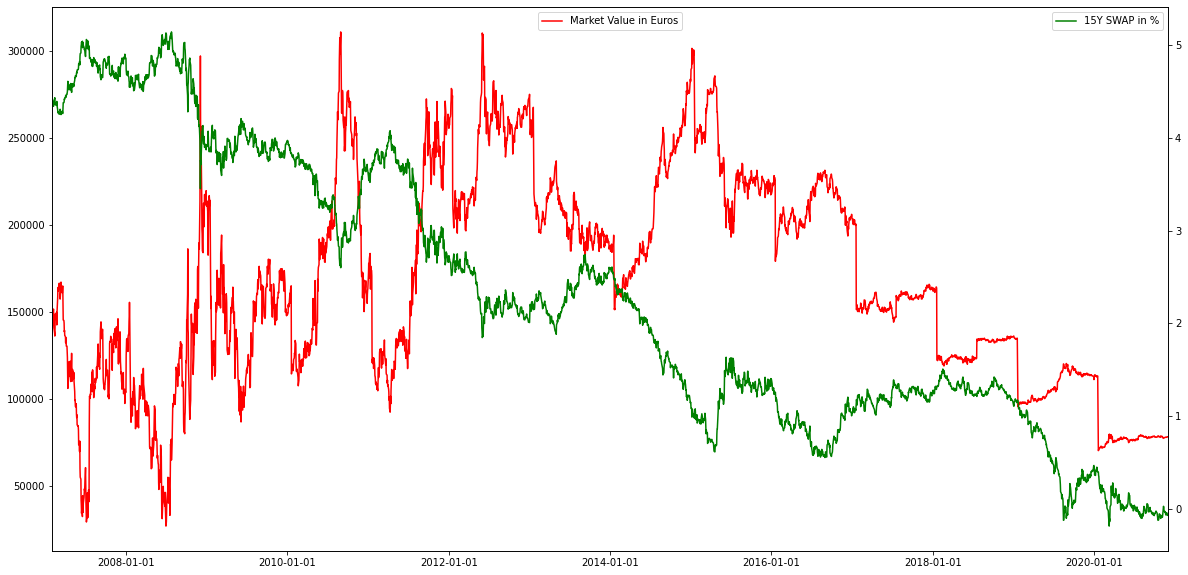

In [670]:
# plot for question 2f

y = market_value_df['Value']
x = market_value_df['Dates']
fig, ax = plt.subplots(figsize=(20, 10))
# plot market value
ax.plot(x, y, color='red', label="Market Value in Euros")
# set the x-axis limits to the range of dates in the data
ax.set_xlim(market_value_df['Dates'].min(), market_value_df['Dates'].max())
# format the x-axis as dates
xfmt = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(xfmt)
# plot 15Y SWAP
ax2 = ax.twinx()
ax2.plot(x, market_value_df['15Y_Swap'], color='green', label='15Y SWAP in %')
ax.legend(loc='upper center')
ax2.legend(loc='upper right')
plt.show()


In [671]:
#Commenting on the graph
'''
The relation we observe in this graph is an inverse one.
As the swap rate is increasing, the market value of the swap decreases. The inverse is also true.
This graph shows the market value of the swap for the party that is long, the bank in this case.
So naturally, given that the bank is paying the euribor 6m, and receiving a fixed rate, when the euribor 6m incrases, the market value of the swap is decreasing.
'''

'\nThe relation we observe in this graph is an inverse one.\nAs the swap rate is increasing, the market value of the swap decreases. The inverse is also true.\nThis graph shows the market value of the swap for the party that is long, the bank in this case.\nSo naturally, given that the bank is paying the euribor 6m, and receiving a fixed rate, when the euribor 6m incrases, the market value of the swap is decreasing.\n'

In [672]:
#Question 2g)

#calculate the market value for 18/December
b=date(2020,12,18)
swaps_hist_dez18=swaps.loc[str(b)].to_frame()
swaps_hist_dez18.columns=['par_rate']
swaps_hist_dez18.reset_index(inplace=True)
swaps_hist_dez18[['instrument', 'maturity']] = swaps_hist_dez18['index'].str.split(' ', expand=True) #splitting the index column to have a columns with only the name of the product
swaps_hist_dez18["maturity"] = swaps_hist_dez18["maturity"].apply(lambda x: x + "M" if "X" in x else x) #adding a M to the FRAs maturities
swaps_hist_dez18['maturity_fra'] = swaps_hist_dez18['maturity'].str.split('X').str[1] #getting the maturity of the fra
swaps_hist_dez18.loc[swaps_hist_dez18["instrument"] == "FRA", "maturity"] = swaps_hist_dez18["maturity_fra"] #getting the new maturity
swaps_hist_dez18["year_frac"] = swaps_hist_dez18["maturity"].apply(extract_number)
swaps_hist_dez18.set_index('index',inplace=True)
forward_hist_dez18=swaps_hist_dez18.loc['FRA 6X12', 'par_rate']
one_year_rate_hist_dez18=(((1+swaps_hist_dez18.loc['Deposit 6M', 'par_rate'])**swaps_hist_dez18.loc['Deposit 6M', 'year_frac'])*(1+forward_hist_dez18)**(1-swaps_hist_dez18.loc['Deposit 6M', 'year_frac']))-1
yield_curve_hist_dez18 = swaps_hist_dez18[swaps_hist_dez18.index.str.contains("FRA") == False]
one_year_rate_hist_dez18 = pd.DataFrame([[one_year_rate_hist_dez18,'-','1Y','-',1.0]],
    index=['Swap 1Y'],
    columns=['par_rate', 'instrument','maturity','maturity_fra','year_frac'])
yield_curve_hist_dez18=yield_curve_hist_dez18.append(one_year_rate_hist_dez18)
yield_curve_hist_dez18.set_index('year_frac',inplace=True)
yield_curve_hist_dez18.loc[0.5, 'df'] = 1 / (1 + (yield_curve_hist_dez18.loc[0.5, 'par_rate']/100) * 0.5)
yield_curve_hist_dez18.loc[0.5, 'zero_rate'] = yield_curve_hist_dez18.loc[0.5, 'par_rate']/100
yield_curve_hist_dez18.loc[1, 'df'] = 1 / (1 + yield_curve_hist_dez18.loc[1, 'par_rate']/100 * 1)
yield_curve_hist_dez18.loc[1, 'zero_rate'] = yield_curve_hist_dez18.loc[1, 'par_rate']/100
yield_curve_hist_dez18=yield_curve_hist_dez18.sort_index()
yield_curve_hist_dez18["Tenor"]= yield_curve_hist_dez18.index
yield_curve_hist_dez18['maturity'] = [b+relativedelta(months=+6)] + [date(b.year +int(n), b.month, b.day) for n in yield_curve_hist_dez18.index[1:]]
for n in range(0,len(yield_curve_hist_dez18['maturity'])):
    yield_curve_hist_dez18.iloc[n,2]=date(yield_curve_hist_dez18.iloc[n,2].year,yield_curve_hist_dez18.iloc[n,2].month,yield_curve_hist_dez18.iloc[n,2].day)
yield_curve_hist_dez18['days'] = yield_curve_hist_dez18.maturity.apply(lambda x: (x - date(b.year,b.month,b.day)).days)
idx_hist=0
row_hist=0
for idx_hist, row_hist in yield_curve_hist_dez18.loc[2:].iterrows():
    prev_dfs = yield_curve_hist_dez18.loc[1:idx_hist-1].df.sum()
    yield_curve_hist_dez18.loc[idx_hist, 'df'] = (1 - row_hist.par_rate/100 * prev_dfs) / (1+row_hist.par_rate/100)
for a in yield_curve_hist_dez18.index[2:]:
    yield_curve_hist_dez18.loc[a,'zero_rate']=((1/yield_curve_hist_dez18.loc[a,'df'])**(1/a))-1
b = date(b.year,b.month,b.day)

pd.options.display.float_format = '{:,.5f}'.format
float_leg_hist_dez18 = pd.DataFrame({'notional': swap_notional, 'start': loan_dates[:-1], 'end': loan_dates[1:]})
float_leg_hist_dez18['dcf'] = float_leg_hist_dez18.apply(lambda x: (x.end - x.start).days / 360, axis=1)
float_leg_hist_dez18['fwd'] = float_leg_hist_dez18.apply(lambda row: getFwd(row.start, row.end), axis=1)
float_leg_hist_dez18.loc[0, 'fwd'] = yield_curve_hist_dez18.loc[0.5, 'par_rate'] / 100
float_leg_hist_dez18['cf'] = float_leg_hist_dez18.notional * float_leg_hist_dez18.dcf * float_leg_hist_dez18.fwd
float_leg_hist_dez18['df'] = float_leg_hist_dez18.end.apply(getDF)
float_leg_hist_dez18['pv'] = float_leg_hist_dez18.cf * float_leg_hist_dez18.df
for n in range(0, len(float_leg_hist_dez18['notional'])):
    if  b>=float_leg_hist_dez18.iloc[n, 2]:
        float_leg_hist_dez18.iloc[n, 7]=0
float_leg_hist_pv_dez18 = float_leg_hist_dez18.pv.sum()
fixed_leg_hist_dez18 = pd.DataFrame({'notional': swap_notional, 'start': loan_dates[::2][:-1], 'end': loan_dates[::2][1:]})
fixed_leg_hist_dez18['dcf'] = 1
fixed_leg_hist_dez18['df'] = fixed_leg_hist_dez18.end.apply(getDF)
fixed_leg_hist_dez18['rate'] = fixed_rate
fixed_leg_hist_dez18['cashflow'] = fixed_leg_hist_dez18.notional * fixed_leg_hist_dez18.dcf * fixed_leg_hist_dez18.rate
fixed_leg_hist_dez18['pv'] = fixed_leg_hist_dez18.cashflow * fixed_leg_hist_dez18.df
for n in range(0, len(fixed_leg_hist_dez18['notional'])):
    if  b>=fixed_leg_hist_dez18.iloc[n, 2]:
        fixed_leg_hist_dez18.iloc[n, 7]=0
fixed_leg_hist_pv_dez18 = fixed_leg_hist_dez18.pv.sum()

mk_value_hist_dez18=fixed_leg_hist_pv_dez18-float_leg_hist_pv_dez18
print("Market values is ", mk_value_hist_dez18)

Market values is  -12744.771745715741


In [673]:
#2g)
float_leg_hist_dez18

,notional,start,end,dcf,fwd,cf,df,pv
0,"1,748,653.15000",2007-01-19,2007-07-19,0.50278,-0.00520,"-4,571.75651",0.98097,0.00000
1,"1,748,653.15000",2007-07-19,2008-01-21,0.51667,0.03985,"36,003.43733",0.96118,0.00000
2,"1,748,653.15000",2008-01-21,2008-07-21,0.50556,0.04169,"36,852.68842",0.94134,0.00000
3,"1,748,653.15000",2008-07-21,2009-01-19,0.50556,0.04258,"37,646.07566",0.92150,0.00000
4,"1,748,653.15000",2009-01-19,2009-07-20,0.50556,0.04038,"35,698.16367",0.90307,0.00000
5,"1,748,653.15000",2009-07-20,2010-01-19,0.50833,0.04123,"36,646.54485",0.88453,0.00000
6,"1,748,653.15000",2010-01-19,2010-07-19,0.50278,0.04043,"35,542.35504",0.86691,0.00000
7,"1,748,653.15000",2010-07-19,2011-01-19,0.51111,0.04128,"36,893.77046",0.84900,0.00000
8,"1,748,653.15000",2011-01-19,2011-07-19,0.50278,0.04080,"35,868.12115",0.83193,0.00000
9,"1,748,653.15000",2011-07-19,2012-01-19,0.51111,0.04167,"37,239.12433",0.81458,0.00000


In [674]:
#2g)
fixed_leg_hist_dez18

,notional,start,end,dcf,df,rate,cashflow,pv
0,"1,748,653.15000",2007-01-19,2008-01-21,1,0.96118,0.04718,"82,494.19546",0.00000
1,"1,748,653.15000",2008-01-21,2009-01-19,1,0.92150,0.04718,"82,494.19546",0.00000
2,"1,748,653.15000",2009-01-19,2010-01-19,1,0.88453,0.04718,"82,494.19546",0.00000
3,"1,748,653.15000",2010-01-19,2011-01-19,1,0.84900,0.04718,"82,494.19546",0.00000
4,"1,748,653.15000",2011-01-19,2012-01-19,1,0.81458,0.04718,"82,494.19546",0.00000
5,"1,748,653.15000",2012-01-19,2013-01-21,1,0.78079,0.04718,"82,494.19546",0.00000
6,"1,748,653.15000",2013-01-21,2014-01-20,1,0.74847,0.04718,"82,494.19546",0.00000
7,"1,748,653.15000",2014-01-20,2015-01-19,1,0.71672,0.04718,"82,494.19546",0.00000
8,"1,748,653.15000",2015-01-19,2016-01-19,1,0.68599,0.04718,"82,494.19546",0.00000
9,"1,748,653.15000",2016-01-19,2017-01-19,1,0.65617,0.04718,"82,494.19546",0.00000


In [675]:
#Question 3

In [676]:
#ex 3a  Alternative 1.
#Description of the Details:
"""swaption says that bank has the option, in 10 years to buy a swap with the exact same characteristics as 
the swap contracted before, to pay X%"""
# >> X% 10Y 5Y

#defining the expiry and the tenor of the swaption and getting the Bachelier Volatility
expiry_swaption = "2017-01-19"
tenor_swaption = "2022-01-19"

swaption_data_exercise = swaption_data.set_index("Expiry")
normalvol = swaption_data_exercise.loc["10Yr"].iloc[4]["NormalVol"]/10000
print(f'Swaption volatolity: {normalvol}')

Swaption volatolity: 0.023648


In [677]:
#defining the dates of the swaption payments

swaption_float_and_swap=float_leg
dates_swaption = []

for n in range(19, len(swaption_float_and_swap["end"])):
    dates_swaption.append(swaption_float_and_swap["end"][n])


dates_swaption=dates_swaption[::2]

In [678]:
#getting the discount factors of the dates previously definined  
dfs_swaption = []

for n in range(0, len(swaption_float_and_swap["df"])):
    for i in range(0, len(dates_swaption)):
        if swaption_float_and_swap["end"][n] != dates_swaption[i]:
            pass
        if swaption_float_and_swap["end"][n] == dates_swaption[i]:
            dfs_swaption.append(swaption_float_and_swap["df"][n])

dfs_swaption

[0.656167769112316,
 0.6274500092316508,
 0.5996471854199216,
 0.5629796931464814,
 0.5262114660041584,
 0.48944323886183516]

In [679]:
#getting the fixed rate payed in this alternative, where it will also be the rate that is used as strike to value the swaption.

A = sum(dfs_swaption[1:])
L = 1748653.15 
T = 5
#strike = X

    
swapRate = ([dfs_swaption[0] - dfs_swaption[-1]] / np.sum(dfs_swaption[1:]))[0]

from scipy.optimize import root

def swaptionPv(rate_swaption):

    fxd_swap = fixed_leg.copy()
    fixed_leg_pv_swap = (fxd_swap.notional * fxd_swap.dcf * fxd_swap.df * rate_swaption).sum()
    
    d = (swapRate - rate_swaption)/(normalvol * np.sqrt(5))
    swaption_pv = A * ((swapRate - rate_swaption)*norm.cdf(d) + normalvol * np.sqrt(5) * norm.pdf(d))
    

    return fixed_leg_pv_swap - float_leg_pv + swaption_pv*swap_notional


res2 = root(swaptionPv, 0)
fixed_rate2 = res2['x'][0]

print(f"Fixed rate And Swaption Strike:\t {fixed_rate2*100}%")

Fixed rate And Swaption Strike:	 3.8588882378637104%


In [680]:
#Exercise 3a: alternative 2

In [681]:
#function to price the caplet
def caplet_price(K,F,sigma,rf,start_date_cap,end_date_cap):
    P = np.exp(-rf*(end_date_cap-today_date).days/360)
    d1 = (np.log(F/K) + (sigma/100)**2 * ((start_date_cap-today_date).days/360) / 2) / ((sigma/100) * np.sqrt((start_date_cap-today_date).days/360))
    d2 = d1 - sigma/100
    caplet = (end_date_cap-start_date_cap).days/360 * P * ( F * norm.cdf(d1) - K * norm.cdf(d2))
    return caplet

In [682]:
#Exercise 3a: alternative 2
#pv_cap = max(euribor - K;0)
#k =6 %
#Description of the Details:
"""we sold a cap to the bank, so we will pay max(int_rate-6%,0)
because we sold the cap, we get premium in moment 0, that will reduce our interest payments, so long as the int rate is below 6%
we also have a regular swap
"""
cap_strike=0.06
          
float_leg_alt2=float_leg
float_leg_alt2["cap_pay"] =1
for n in range(0,len(float_leg_alt2["fwd"])):
    float_leg_alt2.iloc[n,8]=max(float_leg_alt2["fwd"][n]- cap_strike, 0)


#Here we add the volatility for the corresponding strike and interpolate for missing values
float_leg_alt2['tenor'] = [x * 0.5 for x in range(1, len(float_leg_alt2) + 1)]
capnormal_data['Int_Year'] = capnormal_data['Tenor'].apply(lambda x: float(x[:-2]))
capnormal_data_st6=capnormal_data[capnormal_data['Strike']=="6.00%"]
float_leg_alt2 = float_leg_alt2.merge(capnormal_data_st6, left_on='tenor',right_on="Int_Year",how="left")


float_leg_alt2 = float_leg_alt2.set_index('start')
float_leg_alt2['NormalVol'] = float_leg_alt2['NormalVol'].interpolate()
float_leg_alt2 = float_leg_alt2.reset_index()
float_leg_alt2['zero_rate'] = np.nan
for a in range(0,len(float_leg_alt2.iloc[:,9])):
    float_leg_alt2.loc[a,'zero_rate']=((1/float_leg_alt2.loc[a,'df'])**(1/float_leg_alt2.loc[a,'tenor']))-1

#we calculate the caplet price line by line, using the function above
float_leg_alt2['caplet_price'] = np.nan
float_leg_alt2.loc[1:, 'caplet_price'] = float_leg_alt2.loc[1:, :].apply(lambda x: caplet_price(cap_strike, x['fwd'], x['NormalVol']/100, x['zero_rate'], x['start'], x['end']), axis=1)*swap_notional

#the price of the cap is the sum of the caplets
price_cap_alt2=float_leg_alt2['caplet_price'].sum()


#the pv of the float leg will be discounted of the premium of the cap
float_leg_pv_alt2 = float_leg_alt2.pv.sum()-price_cap_alt2
fixed_leg_alt2=fixed_leg
fixed_rate_alt2 = float_leg_pv_alt2 / (fixed_leg_alt2.notional *  fixed_leg_alt2.dcf * fixed_leg_alt2.df).sum()
print(f"Fair fixed rate is: {fixed_rate_alt2 * 100:.4f}%")

Fair fixed rate is: 4.6051%


In [683]:
#function to price the floor
def floorlet_price(K,F,sigma,rf,start_date_cap,end_date_cap):
    P = np.exp(-rf*(end_date_cap-today_date).days/360)
    d1 = (np.log(F/K) + (sigma/100)**2 * ((start_date_cap-today_date).days/360) / 2) / ((sigma/100) * np.sqrt((start_date_cap-today_date).days/360))
    d2 = d1 - sigma/100
    caplet = (end_date_cap-start_date_cap).days/360 * P * ( -F * norm.cdf(-d1) + K * norm.cdf(-d2))
    return caplet

In [684]:
#pv_cap = max(euribor - K;0)
#k =6 %
#Description of the Details:
"""we will be paying and receiving the euribor 6m, so it nets out at 0
but we bought caps(strike 6%), floor(strike X%), so we will pay a premium in moment 0
"""
float_leg_alt3=float_leg_alt2

#adding the volatility to the data frame
capnormal_data_st2=capnormal_data[capnormal_data['Strike']=="4.00%"]
float_leg_alt3 = float_leg_alt3.merge(capnormal_data_st2, left_on='tenor',right_on="Int_Year",how="left")

float_leg_alt3 = float_leg_alt3.set_index('start')
float_leg_alt3['NormalVol_y'] = float_leg_alt3['NormalVol_y'].interpolate()
float_leg_alt3 = float_leg_alt3.reset_index()

price_cap_3a=float_leg_alt3['caplet_price'].sum()


float_leg_alt3

,start,notional,end,dcf,fwd,cf,df,pv,cap_pay,tenor,Tenor_x,Strike_x,NormalVol_x,Int_Year_x,zero_rate,caplet_price,Tenor_y,Strike_y,NormalVol_y,Int_Year_y
0,2007-01-19,"1,748,653.15000",2007-07-19,0.50278,0.03880,"34,112.33706",0.98097,"33,463.15191",0.00000,0.50000,NaN,NaN,NaN,NaN,0.03918,NaN,NaN,NaN,NaN,NaN
1,2007-07-19,"1,748,653.15000",2008-01-21,0.51667,0.03985,"36,003.43733",0.96118,"34,605.75683",0.00000,1.00000,1Yr,6.00%,112.34000,1.00000,0.04039,0.00000,1Yr,4.00%,107.52000,1.00000
2,2008-01-21,"1,748,653.15000",2008-07-21,0.50556,0.04169,"36,852.68842",0.94134,"34,690.93149",0.00000,1.50000,NaN,NaN,111.95500,NaN,0.04112,-0.00000,NaN,NaN,107.72500,NaN
3,2008-07-21,"1,748,653.15000",2009-01-19,0.50556,0.04258,"37,646.07566",0.92150,"34,690.93149",0.00000,2.00000,2Yr,6.00%,111.57000,2.00000,0.04172,-0.00000,2Yr,4.00%,107.93000,2.00000
4,2009-01-19,"1,748,653.15000",2009-07-20,0.50556,0.04038,"35,698.16367",0.90307,"32,237.80296",0.00000,2.50000,NaN,NaN,116.54000,NaN,0.04163,-0.00000,NaN,NaN,105.47000,NaN
5,2009-07-20,"1,748,653.15000",2010-01-19,0.50833,0.04123,"36,646.54485",0.88453,"32,414.93374",0.00000,3.00000,3Yr,6.00%,121.51000,3.00000,0.04175,-0.00000,3Yr,4.00%,103.01000,3.00000
6,2010-01-19,"1,748,653.15000",2010-07-19,0.50278,0.04043,"35,542.35504",0.86691,"30,811.97511",0.00000,3.50000,NaN,NaN,115.29500,NaN,0.04165,-0.00000,NaN,NaN,102.92500,NaN
7,2010-07-19,"1,748,653.15000",2011-01-19,0.51111,0.04128,"36,893.77046",0.84900,"31,322.67083",0.00000,4.00000,4Yr,6.00%,109.08000,4.00000,0.04177,-0.00000,4Yr,4.00%,102.84000,4.00000
8,2011-01-19,"1,748,653.15000",2011-07-19,0.50278,0.04080,"35,868.12115",0.83193,"29,839.82821",0.00000,4.50000,NaN,NaN,109.08000,NaN,0.04174,-0.00000,NaN,NaN,102.80500,NaN
9,2011-07-19,"1,748,653.15000",2012-01-19,0.51111,0.04167,"37,239.12433",0.81458,"30,334.41100",0.00000,5.00000,5Yr,6.00%,109.08000,5.00000,0.04187,-0.00000,5Yr,4.00%,102.77000,5.00000


In [685]:
#function to get the strike
#we solve for a strike that cancels out the prices of the cap and the floor, so that the market value at time 0 is equal to 0
def alt3Pv(strike):
    #Present Value of the swap
    list_of_floor_prices= float_leg_alt3.loc[1:, :].apply(lambda x: floorlet_price(strike, x['fwd'], x['NormalVol_y']/100, x['zero_rate'], x['start'], x['end']), axis=1)*swap_notional
    price_floor_3a=sum(list_of_floor_prices)
    float_leg_pv_alt3 = float_leg_alt3.pv.sum()

    return  price_cap_3a-price_floor_3a

res_alt3 = root(alt3Pv,1)
strike_alt3 = res_alt3['x'][0]
print(f'Strike of the floor for alternative 3: {strike_alt3*100:.4}%')

Strike of the floor for alternative 3: 4.352%


In [689]:
#Exercise 3b
"""
In mathematical terms the choice is irrelevant.
At time 0, all decisions produce a market value of 0, and any fluctuation is "impossible" to predict
However, financial expertise can lead you to try and pick a better alternative, based on experience in the market
and your risk aversion/appetite.

Alternative 1:
We would personally not choose alternative 1, as we fear that after the 10 year, the bank cancells our swap
In this case, we would incurr in increased costs with our loan, which would then be mitigated by a new swap
Obviously that swap would have a much higher rate

Alternative 2:
In this alternative we are short an option (cap).
We have the benefit og receiving a payoff at time 0, the premium of the option
But in this case our downside is infinite
We don't know where rates are going, and we would rather pay a higher monthy fee, but know that our installments can't skyorkcet

Alternative 3:
We would choose this alternative, even though we won't be perfectly hedging the installments of our loan
In this case we accept that we pay some premium up front, but we have some ease of mind regarding potential increases in the euribor
In this alternative we don't have a swap, but if no big shifts happen, we know that we will be paying euribor between two set values (the strikes of the cap and the floor)
In any case, we are hedged against big shifts in the euribor, we will never pay more than 6%
If the euribor goes below the strike of the floor, we even receive some extra payments
"""

'\nIn mathematical terms the choice is irrelevant.\nAt time 0, all decisions produce a market value of 0, and any fluctuation is "impossible" to predict\nHowever, financial expertise can lead you to try and pick a better alternative, based on experience in the market\nand your risk aversion/appetite.\n\nAlternative 1:\nWe would personally not choose alternative 1, as we fear that after the 10 year, the bank cancells our swap\nIn this case, we would incurr in increased costs with our loan, which would then be mitigated by a new swap\nObviously that swap would have a much higher rate\n\nAlternative 2:\nIn this alternative we are short an option (cap).\nWe have the benefit og receiving a payoff at time 0, the premium of the option\nBut in this case our downside is infinite\nWe don\'t know where rates are going, and we would rather pay a higher monthy fee, but know that our installments can\'t skyorkcet\n\nAlternative 3:\nWe would choose this alternative, even though we won\'t be perfectly

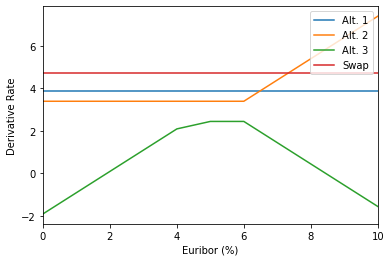

In [691]:
#3 c)
euribor_range = [x for x in range(0,11)] #create a list from 0 to 10

#swap
fixed_rate_pay=np.repeat(fixed_rate1*100, 11)

#alt1
pay_rate_fixed1 = fixed_rate2 * 100
pay_rate_float = []
net_rate1 = []
#Loop to append our data into lists
for idx, rate in enumerate(euribor_range):
    pay_rate_float.append(rate)
    net_rate1.append(pay_rate_fixed1)#- pay_rate_float[idx])

#alt2
cost_alt2=price_cap_alt2/swap_notional*100
pay_rate_fixed2 = fixed_rate_alt2 * 100
strike_cap = 6
cap_pay = []
net_rate2 = []
#Loop to append our data into lists
for idx, rate in enumerate(euribor_range):
    if rate > strike_cap:
        cap_pay.append(rate-strike_cap)
    else:
        cap_pay.append(0)
    net_rate2.append(pay_rate_fixed2 + cap_pay[idx]-cost_alt2) #-pay_rate_float[idx]+ cap_pay[idx])

#alt3
cost_alt3=((price_cap_alt2+price_floor_3a)/swap_notional)*100
floor_strike=strike_alt3*100 #floor strike
cap_pay_2 = []
floor_pay=[]
net_rate3=[]
#Loop to append our data into lists
for idx, rate in enumerate(euribor_range):
    if rate > strike_cap:
        cap_pay_2.append(rate-strike_cap)
        floor_pay.append(0)
    elif rate < floor_strike:
        floor_pay.append(floor_strike-rate)
        cap_pay_2.append(0)
    else:
        cap_pay_2.append(0)
        floor_pay.append(0)
    net_rate3.append( -cap_pay_2[idx]-floor_pay[idx]+cost_alt3)

#ploting our alternatives against our swap
plt.plot(net_rate1, label="Alt. 1")
plt.plot(net_rate2, label="Alt. 2")
plt.plot(net_rate3, label="Alt. 3")
plt.plot(fixed_rate_pay, label="Swap")
plt.xlim(0, 10)
plt.xlabel ("Euribor (%)")
plt.ylabel ("Derivative Rate")
plt.legend (loc="upper right")

In [ ]:
#By looking at this grpah, we feel like all alternatives make sense, except for alternative 3
#By looking at this graph we see that that alternative completely outperforms the others, which would be too good to be true
#If this was the case, nobody would enter into swap agrements, as this strategy would totally dominate a swap. Market forces would then correct these prices
#In this alternative, the premium we pay for the options is the factor that should have balanced the payoffs
#So, we can assume that (at least) the value that we calculated for both the cap price and floor price, are wrong
#Looking at alternative 2, that also has a cap, we see that the values make sense in financial terms, so we feel like the mistake is in the price of the floor